In [51]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt


In [25]:
class FullyConnectedDNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(FullyConnectedDNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)  # Input layer to hidden layer
        self.fc2 = nn.Linear(hidden_size, hidden_size) # Additional hidden layer
        self.fc3 = nn.Linear(hidden_size, hidden_size) # Additional hidden layer
        self.fc4 = nn.Linear(hidden_size, output_size) # Hidden layer to output layer

    def forward(self, x):
        x = F.relu(self.fc1(x))   # Activation function for hidden layer
        x = F.relu(self.fc2(x))   # Activation function for second hidden layer
        x = F.relu(self.fc3(x))   # Activation function for third hidden layer
        x = self.fc4(x)           # No activation for the output layer in regression
        return x

In [26]:
# Automatic selection of device: MPS for Apple Silicon, CUDA for NVIDIA GPUs if available, otherwise CPU
if torch.backends.mps.is_available():
    device = torch.device('mps')
elif torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')

print("Using device:", device)

Using device: mps


## **Simple Bechmark Model**

In [27]:
# 2 Inputs and 2 Outputs for the simple benchmark model
num_states = 2
input_size = 2
hidden_size = 16  # 16 hidden nodes
output_size = 2
epochs = 20
batch_size = 64

simple_model = FullyConnectedDNN(input_size, hidden_size, output_size)
simple_model.to(device)

FullyConnectedDNN(
  (fc1): Linear(in_features=2, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=16, bias=True)
  (fc3): Linear(in_features=16, out_features=16, bias=True)
  (fc4): Linear(in_features=16, out_features=2, bias=True)
)

In [28]:
simple_criterion = nn.MSELoss()
simple_optimizer = torch.optim.Adam(simple_model.parameters(), lr=0.001)

In [29]:
def dataLoader(data, num_states, batch_size=64):
    # Split data into inputs (features) and outputs (labels)
    X = data[:, :num_states]    # States in time t
    Y = data[:, num_states:]    # States in time t+1

    # Convert to PyTorch tensors
    X_tensor = torch.from_numpy(X).float()
    Y_tensor = torch.from_numpy(Y).float()

    # Create a dataset from the tensors
    dataset = TensorDataset(X_tensor, Y_tensor)

    # Create a data loader from the dataset
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return data_loader

In [32]:
# Load training data
simple_dataTrain = np.load('datasets/DiscreteStateSpace/train_data.npy')
# Load validation data
simple_dataVal = np.load('datasets/DiscreteStateSpace/val_data.npy')

simple_train_loader = dataLoader(simple_dataTrain, num_states, batch_size)
simple_val_loader = dataLoader(simple_dataVal, num_states, batch_size)

In [33]:
def train_model(model, train_loader, val_loader, criterion, optimizer):

    # Initialize lists to store the loss history
    train_losses = []
    val_losses = []
    # Initialize the tqdm bar for epochs
    epoch_bar = tqdm(range(epochs), desc="Training", position=0)

    # Main training loop
    for epoch in epoch_bar:
        epoch_train_loss = 0.0
        # Initialize the tqdm bar for batches
        batch_bar = tqdm(train_loader, leave=False, position=1, desc=f"Epoch {epoch+1}/{epochs}")

        for inputs, targets in batch_bar:
            # Move the data to the device
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()  # Clear the gradients
            outputs = model(inputs)  # Get the outputs for the current batch
            loss = criterion(outputs, targets)  # Calculate the loss
            loss.backward()  # Perform backpropagation
            optimizer.step()  # Update the weights

            # Accumulate the loss for the epoch
            epoch_train_loss += loss.item()

            # Update the progress bar for each batch
            batch_bar.set_postfix(loss=loss.item())
            batch_bar.update()  # This is important to call

        # Calculate and store the average loss for the epoch
        avg_epoch_loss = epoch_train_loss / len(train_loader)
        train_losses.append(avg_epoch_loss)

        # Validation phase
        model.eval()  # Set the model to evaluation mode
        epoch_val_loss = 0.0
        with torch.no_grad():  # No need to track the gradients
            for inputs, targets in val_loader:
                # Move the data to the device
                inputs, targets = inputs.to(device), targets.to(device)
                # Forward pass
                outputs = model(inputs)
                # Calculate the loss
                val_loss = criterion(outputs, targets)
                # Accumulate the validation loss
                epoch_val_loss += val_loss.item()

        # Calculate and store the average validation loss for the epoch
        avg_val_loss = epoch_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        # Update the outer loop with the average training and validation loss
        epoch_bar.set_postfix(train_loss=avg_epoch_loss, val_loss=avg_val_loss)
    return model, train_losses, val_losses

In [34]:
simple_model, simple_train_losses, simple_val_losses = train_model(simple_model, simple_train_loader, simple_val_loader, simple_criterion, simple_optimizer)

Training:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1/20:   0%|          | 0/4683 [00:00<?, ?it/s]

Epoch 2/20:   0%|          | 0/4683 [00:00<?, ?it/s]

Epoch 3/20:   0%|          | 0/4683 [00:00<?, ?it/s]

Epoch 4/20:   0%|          | 0/4683 [00:00<?, ?it/s]

Epoch 5/20:   0%|          | 0/4683 [00:00<?, ?it/s]

Epoch 6/20:   0%|          | 0/4683 [00:00<?, ?it/s]

Epoch 7/20:   0%|          | 0/4683 [00:00<?, ?it/s]

Epoch 8/20:   0%|          | 0/4683 [00:00<?, ?it/s]

Epoch 9/20:   0%|          | 0/4683 [00:00<?, ?it/s]

Epoch 10/20:   0%|          | 0/4683 [00:00<?, ?it/s]

Epoch 11/20:   0%|          | 0/4683 [00:00<?, ?it/s]

Epoch 12/20:   0%|          | 0/4683 [00:00<?, ?it/s]

Epoch 13/20:   0%|          | 0/4683 [00:00<?, ?it/s]

Epoch 14/20:   0%|          | 0/4683 [00:00<?, ?it/s]

Epoch 15/20:   0%|          | 0/4683 [00:00<?, ?it/s]

Epoch 16/20:   0%|          | 0/4683 [00:00<?, ?it/s]

Epoch 17/20:   0%|          | 0/4683 [00:00<?, ?it/s]

Epoch 18/20:   0%|          | 0/4683 [00:00<?, ?it/s]

Epoch 19/20:   0%|          | 0/4683 [00:00<?, ?it/s]

Epoch 20/20:   0%|          | 0/4683 [00:00<?, ?it/s]

In [35]:
def plot_learning_curves(train_losses, val_losses, model_name='Simple Model'):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss', linestyle='--')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'Training and Validation Loss Over Time - {model_name}')
    plt.legend()
    plt.show()

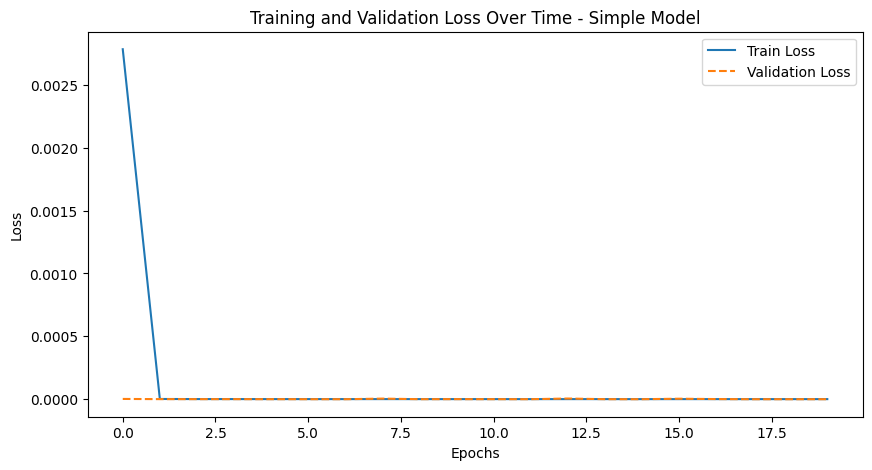

In [36]:
plot_learning_curves(simple_train_losses, simple_val_losses, model_name='Simple Model')

In [37]:
def plot_simulation(data, sim_num, model, num_states, model_name='Simple Model'):
    # Get simulation data
    sim_data = data[sim_num*999:(sim_num+1)*999, :]
    
    # Separate inputs and outputs
    X = sim_data[:, :num_states]        # States at time t
    Y_true = sim_data[:, num_states:]   # States at time t+dt
    
    # Convert to PyTorch tensors
    X_tensor = torch.from_numpy(X).float().to(device)
    
    # Get predictions from the model
    model.eval()  
    with torch.no_grad():
        Y_pred = model(X_tensor).cpu().numpy()  # Move the predictions to the CPU and convert to NumPy array
    
    mse = np.mean((Y_true - Y_pred) ** 2)

    # Plot the simulation
    plt.figure(figsize=(10, 6))
    plt.plot(Y_true[:, 0], Y_true[:, 1], label='Real data')
    plt.plot(Y_pred[:, 0], Y_pred[:, 1], '--', label='Predicted data')
    plt.xlabel('X1(t+dt)')
    plt.ylabel('X2(t+dt)')
    plt.title(f'{model_name} - Simulation {sim_num}')
    mse_str = f"{mse:.2e}"
    plt.text(0.05, 0.15, f'MSE: {mse_str}', transform=plt.gca().transAxes, fontsize=12, va='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    plt.legend()
    plt.show()

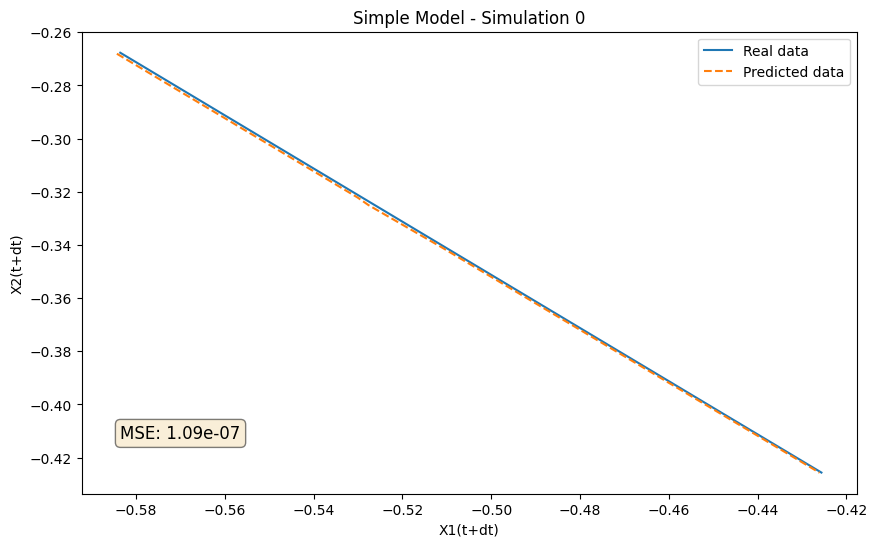

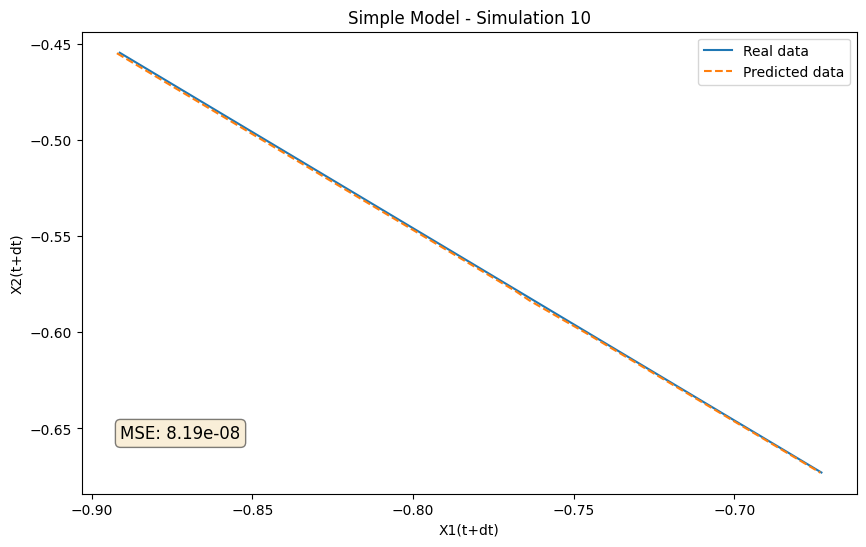

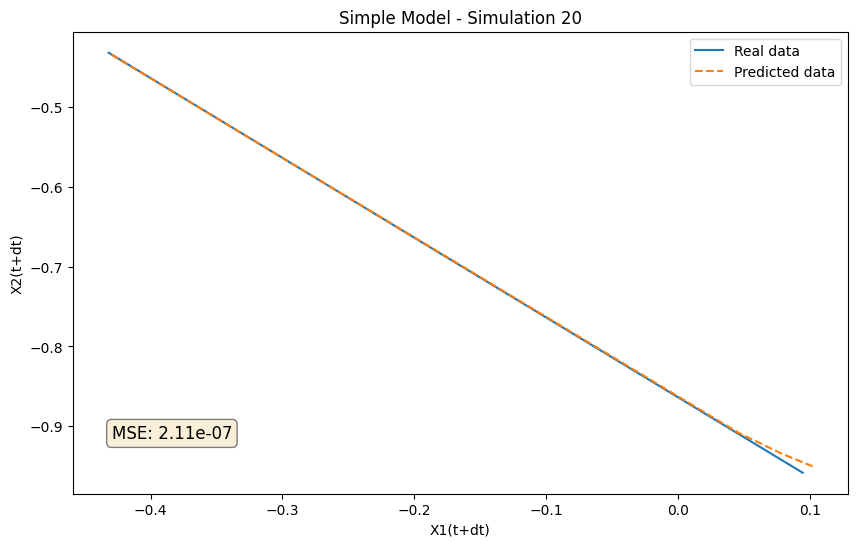

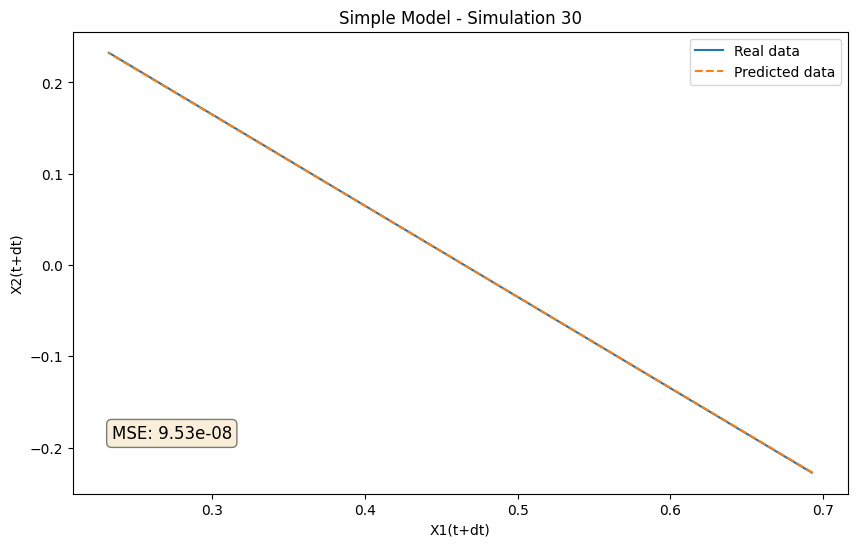

In [39]:
# Plot several simulations on the test data
simple_dataTest = np.load('datasets/DiscreteStateSpace/test_data.npy')

plot_simulation(simple_dataTest, 0, simple_model, num_states, 'Simple Model')
plot_simulation(simple_dataTest, 10, simple_model, num_states, 'Simple Model')
plot_simulation(simple_dataTest, 20, simple_model, num_states, 'Simple Model')
plot_simulation(simple_dataTest, 30, simple_model, num_states, 'Simple Model')

## **Complex Benchmark Model** (Anesthesia)

In [40]:
# 4 Inputs and 4 Outputs for the complex benchmark model
num_states = 4
input_size = 4
hidden_size = 16  # 16 hidden nodes
output_size = 4
epochs = 20
batch_size = 64

complex_model = FullyConnectedDNN(input_size, hidden_size, output_size)
complex_model.to(device)

FullyConnectedDNN(
  (fc1): Linear(in_features=4, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=16, bias=True)
  (fc3): Linear(in_features=16, out_features=16, bias=True)
  (fc4): Linear(in_features=16, out_features=4, bias=True)
)

In [41]:
complex_criterion = nn.MSELoss()
complex_optimizer = torch.optim.Adam(complex_model.parameters(), lr=0.001)

In [42]:
# Load training data
complex_dataTrain = np.load('datasets/Anesthesia/train_data.npy')
# Load validation data
complex_dataVal = np.load('datasets/Anesthesia/val_data.npy')

complex_train_loader = dataLoader(complex_dataTrain, num_states, batch_size)
complex_val_loader = dataLoader(complex_dataVal, num_states, batch_size)

In [43]:
complex_model, complex_train_losses, complex_val_losses = train_model(complex_model, complex_train_loader, complex_val_loader, complex_criterion, complex_optimizer)

Training:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1/20:   0%|          | 0/4683 [00:00<?, ?it/s]

Epoch 2/20:   0%|          | 0/4683 [00:00<?, ?it/s]

Epoch 3/20:   0%|          | 0/4683 [00:00<?, ?it/s]

Epoch 4/20:   0%|          | 0/4683 [00:00<?, ?it/s]

Epoch 5/20:   0%|          | 0/4683 [00:00<?, ?it/s]

Epoch 6/20:   0%|          | 0/4683 [00:00<?, ?it/s]

Epoch 7/20:   0%|          | 0/4683 [00:00<?, ?it/s]

Epoch 8/20:   0%|          | 0/4683 [00:00<?, ?it/s]

Epoch 9/20:   0%|          | 0/4683 [00:00<?, ?it/s]

Epoch 10/20:   0%|          | 0/4683 [00:00<?, ?it/s]

Epoch 11/20:   0%|          | 0/4683 [00:00<?, ?it/s]

Epoch 12/20:   0%|          | 0/4683 [00:00<?, ?it/s]

Epoch 13/20:   0%|          | 0/4683 [00:00<?, ?it/s]

Epoch 14/20:   0%|          | 0/4683 [00:00<?, ?it/s]

Epoch 15/20:   0%|          | 0/4683 [00:00<?, ?it/s]

Epoch 16/20:   0%|          | 0/4683 [00:00<?, ?it/s]

Epoch 17/20:   0%|          | 0/4683 [00:00<?, ?it/s]

Epoch 18/20:   0%|          | 0/4683 [00:00<?, ?it/s]

Epoch 19/20:   0%|          | 0/4683 [00:00<?, ?it/s]

Epoch 20/20:   0%|          | 0/4683 [00:00<?, ?it/s]

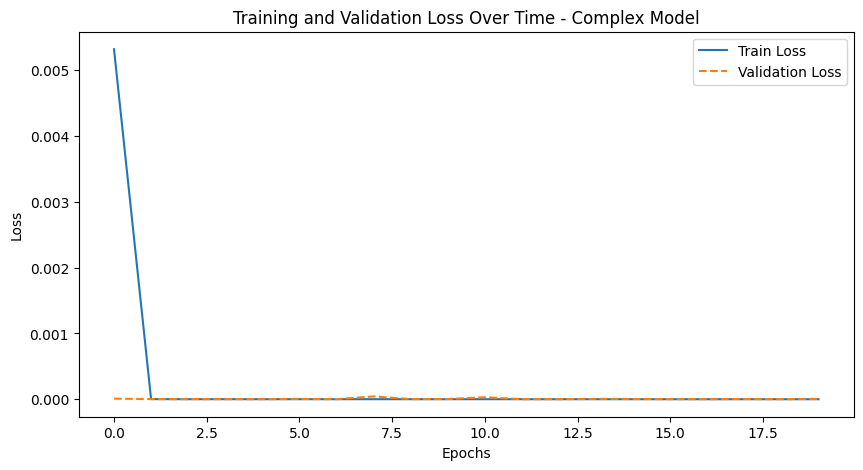

In [46]:
plot_learning_curves(complex_train_losses, complex_val_losses, model_name='Complex Model')

In [69]:
def plot_complex_simulation(data, sim_num, model, num_states, model_name='Complex Model'):
    # Prepare figure with subplots
    fig, axs = plt.subplots(2, 2, figsize=(15, 10))  # Create a 2x2 grid of subplots
    fig.suptitle(f'{model_name} - Simulation {sim_num}')
    axs = axs.flatten()  # Flatten the 2D array of axes for easy iteration

    # Get simulation data
    sim_data = data[sim_num*999:(sim_num+1)*999, :]

    # Loop through each variable (state)
    for var_num in range(num_states):
        # Separate inputs and outputs for the current variable
        X = sim_data[:, :num_states]  # States at time t
        Y_true = sim_data[:, num_states:]  # States at time t+dt

        # Convert to PyTorch tensors
        X_tensor = torch.from_numpy(X).float().to(device)

        # Get predictions from the model
        model.eval()
        with torch.no_grad():
            Y_pred = model(X_tensor).cpu().numpy()  # Move the predictions to the CPU and convert to NumPy array

        mse = np.mean((Y_true[:, var_num] - Y_pred[:, var_num]) ** 2)

        # Plot the simulation for the current variable
        axs[var_num].plot(range(len(Y_true)), Y_true[:, var_num], label='Real data')
        axs[var_num].plot(range(len(Y_pred)), Y_pred[:, var_num], '--', label='Predicted data')
        axs[var_num].set_title(f'Variable X{var_num+1}')
        mse_str = f"{mse:.2e}"
        axs[var_num].text(0.05, 1.08, f'MSE: {mse_str}', transform=axs[var_num].transAxes, fontsize=12, va='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
        axs[var_num].legend()

    # Set common labels
    for ax in axs:
        ax.set_xlabel('Time Step')
        ax.set_ylabel('Value')
    
    # Adjust layout to prevent overlapping
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


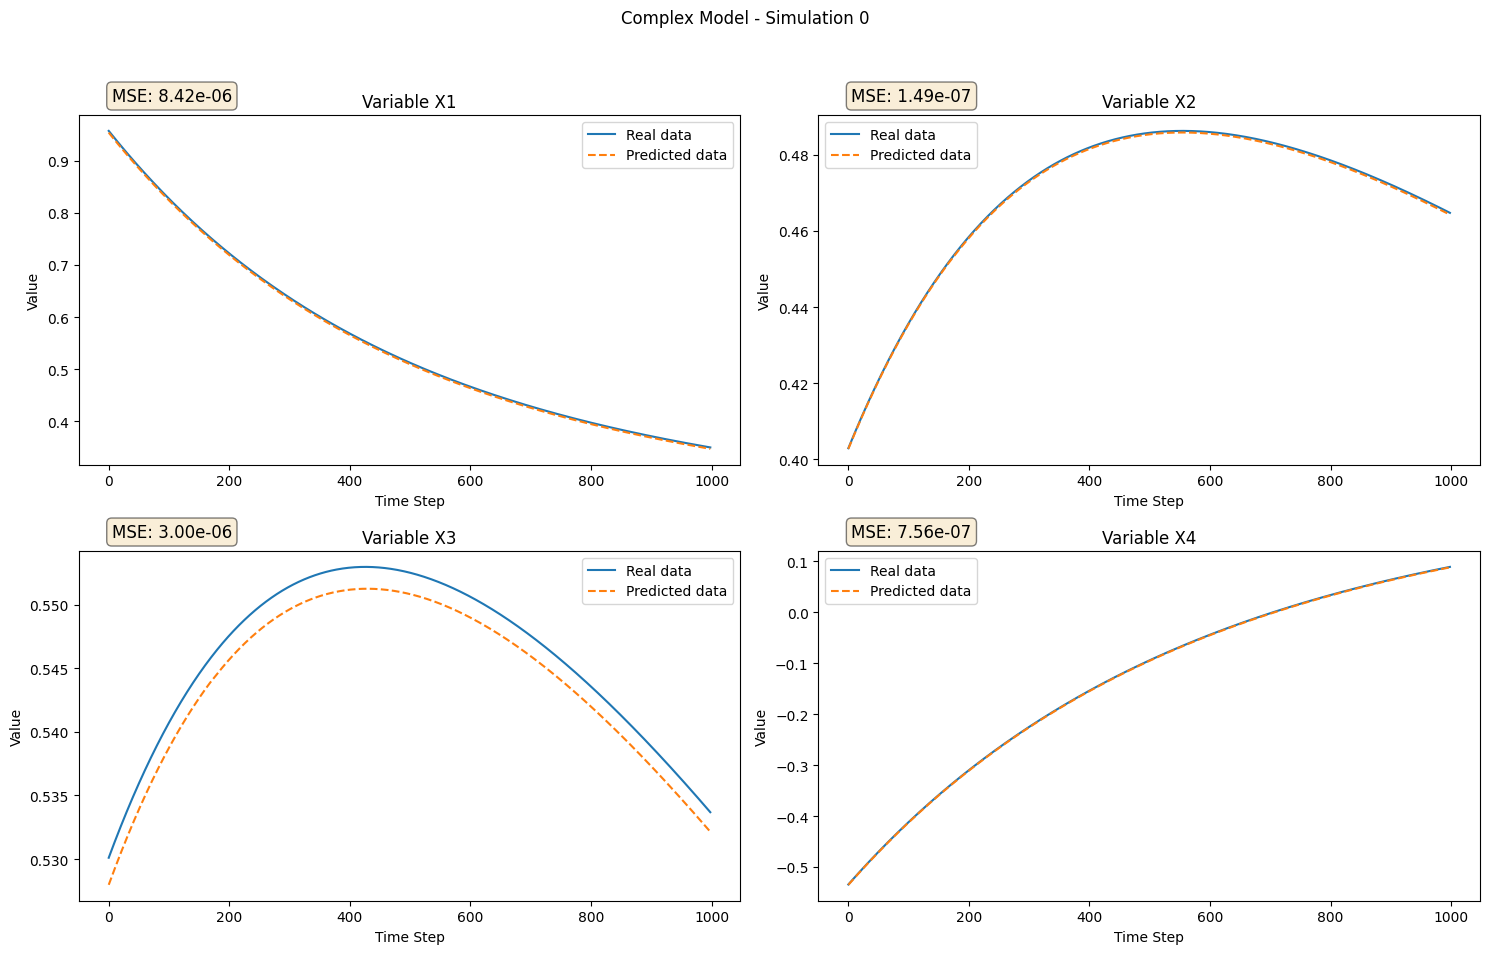

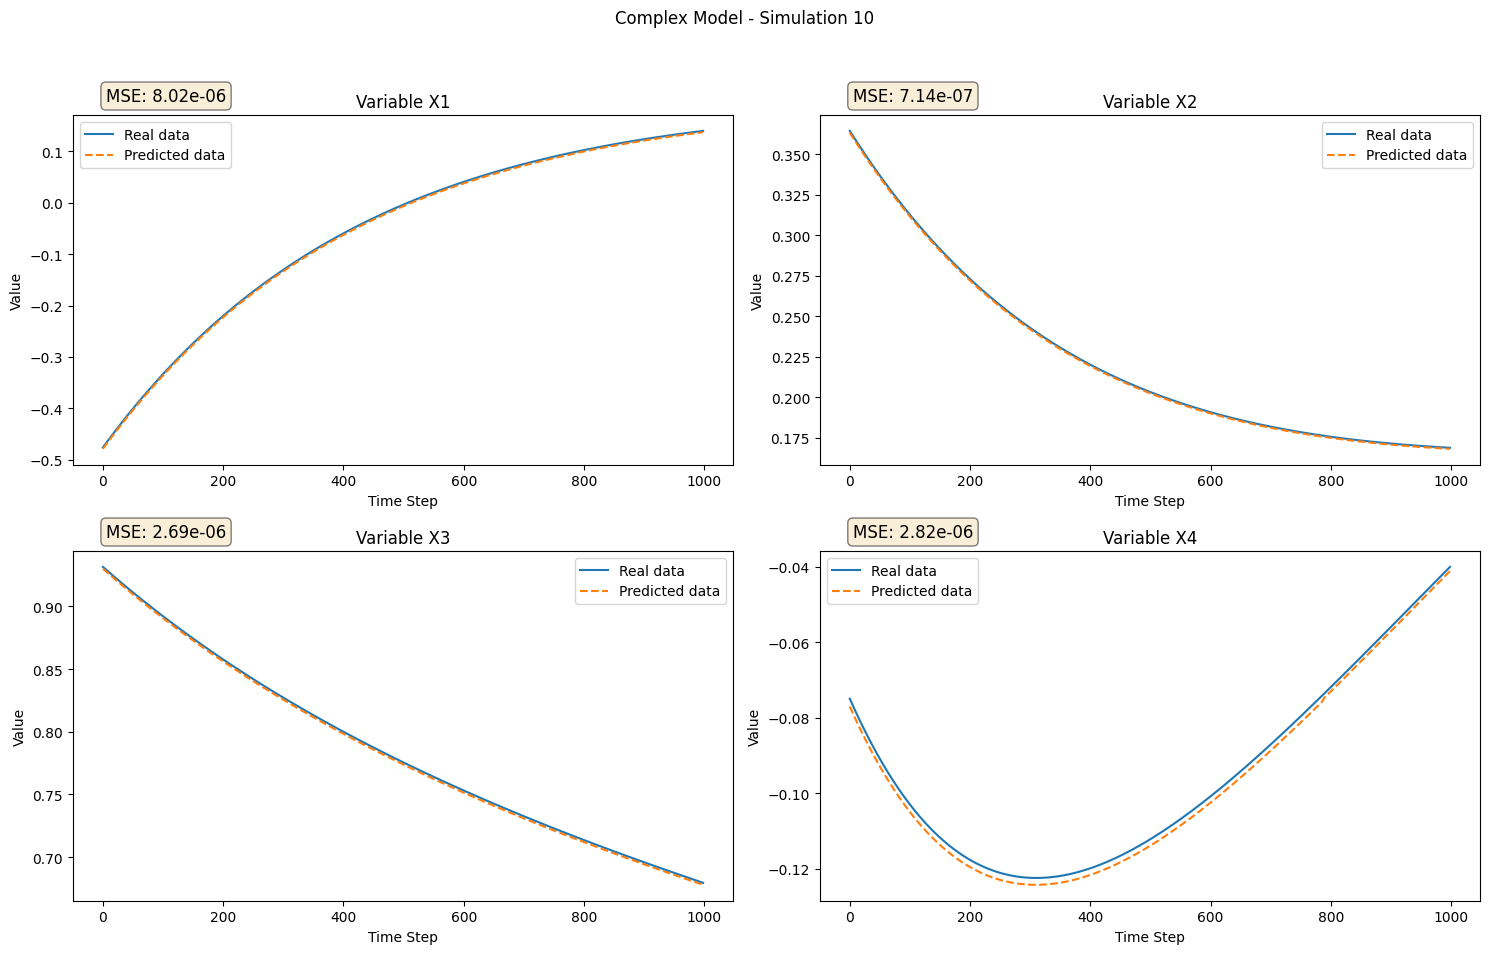

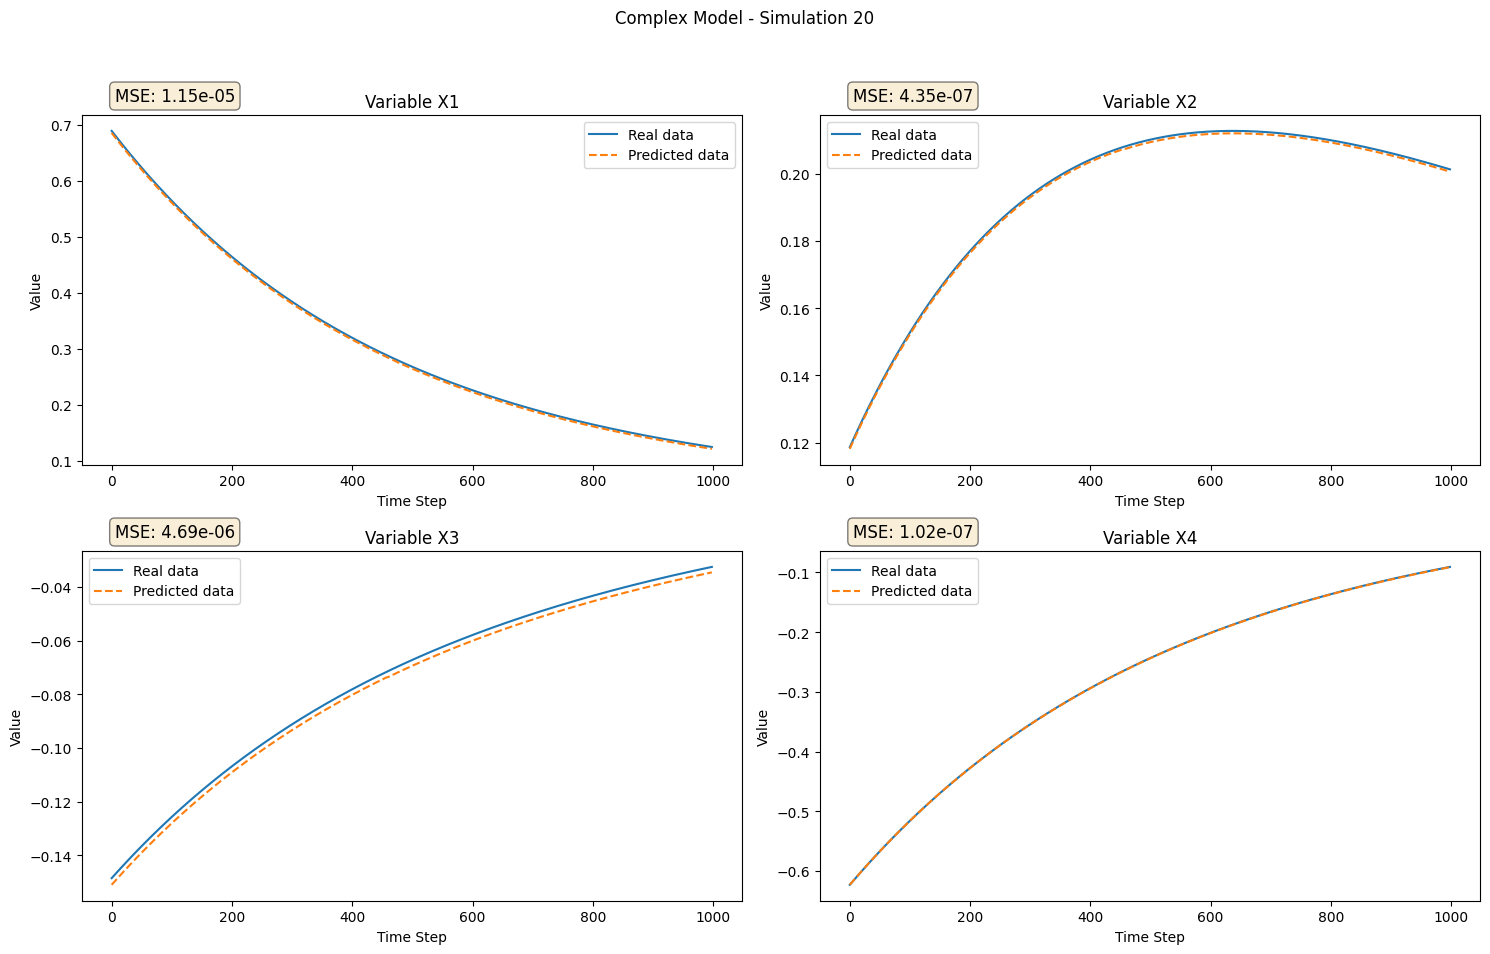

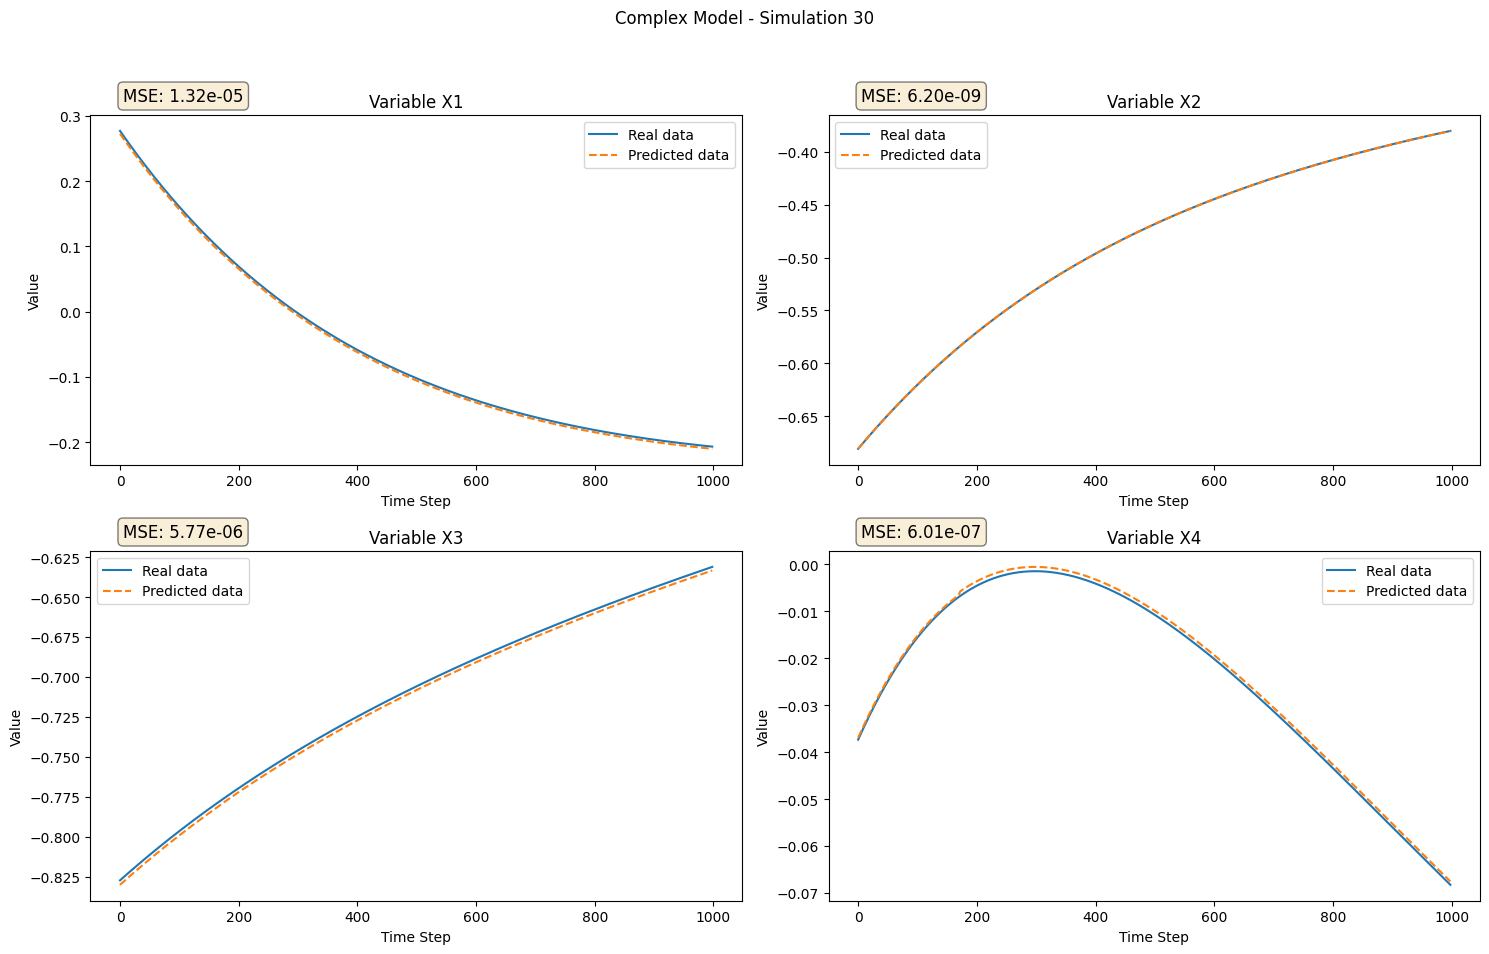

In [70]:
# Plot several simulations on the test data
complex_dataTest = np.load('datasets/Anesthesia/test_data.npy')

plot_complex_simulation(complex_dataTest, sim_num=0, model=complex_model, num_states=4, model_name='Complex Model')
plot_complex_simulation(complex_dataTest, sim_num=10, model=complex_model, num_states=4, model_name='Complex Model')
plot_complex_simulation(complex_dataTest, sim_num=20, model=complex_model, num_states=4, model_name='Complex Model')
plot_complex_simulation(complex_dataTest, sim_num=30, model=complex_model, num_states=4, model_name='Complex Model')